## Задача
1. Необходимо разработать демонстрационную версию поиска изображений по запросу.
2. Для демонстрационной версии нужно обучить модель. Модель получает векторное представление изображения, векторное представление текста, а на выходе должна выдавать число от 0 до 1, отражающее соответствие текста и картинки.

In [1]:
import pandas as pd
import numpy as np
import os
import random
from scipy.stats import randint, uniform
import spacy
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import torch
import transformers
import tensorflow as tf
import lightgbm as lgb
from optuna.integration.lightgbm import LightGBMPruningCallback

from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import notebook
from tqdm import tqdm
from transformers import BertTokenizer
from PIL import Image
from torchvision import models, transforms

### Загрузка файла с мнением экспертов 

In [2]:
# Путь к папке с данными проекта
path_to_prj = '/Users/naziaignatenko/Public/PRACTICUM_YANDEX/Projects/project_5/project_5_data/'

In [3]:
# Загрузка файла с оценкой эксперртов
try:
    expert_df = pd.read_csv(path_to_prj + 'ExpertAnnotations.tsv', 
                        sep='\t', names=['image', 'description_id', 'expert1', 'expert2', 'expert3'])
except: print('Неверный путь')
expert_df.head()

image               description_id  expert1  expert2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1        1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2        1        1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2        1        1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2        1        2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2        1        1   

   expert3  
0        1  
1        2  
2        2  
3        2  
4        2

In [4]:
expert_df.shape

(5822, 5)

In [5]:
expert_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image           5822 non-null   object
 1   description_id  5822 non-null   object
 2   expert1         5822 non-null   int64 
 3   expert2         5822 non-null   int64 
 4   expert3         5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [6]:
# Проверка  уникальных значений в колонках с оценками экспертов
columns = ['expert1', 'expert2', 'expert3']
for column in columns:
    print(expert_df[column].unique())

[1 2 3 4]
[1 2 3 4]
[1 2 3 4]


In [7]:
# Проверка уникальных комбинаций image и description_id
print(f"Уникальных комбинаций image и description_id: {expert_df[['image', 'description_id']].drop_duplicates().shape[0]}")

Уникальных комбинаций image и description_id: 5822


### Выводы по анализу датафрейма с оценкой экспертов
1. Датафрейм содержит 5 столбцов, из которых три относятся к оценкам трех разных экспертов, и 5822 строк.
2. Данные в столбцах с оценками экспертов (3 столбца) относятся к типу int, а ID изображений и текстов относятся к типу object.
3. Пропущенные значения отсутствуют.
4. Все комбинации изображений с соответствующими описаниями являются уникальными, дубликатов нет.
5. Максимальная оценка эксперта соотвествует 4, а минимальная равна 0.

### Вычисление нормализованного показателя оценки экспертов

In [8]:
# Сумма оценок всех экспертов для каждой строки
expert_df["total_expert_score"] = expert_df["expert1"] + expert_df["expert2"] + expert_df["expert3"]

# Максимально возможный балл (количество экспертов * максимальный балл от каждого эксперта)
max_total_expert_score = 3 * 4

# Расчет нормализованного результата
expert_df["normalized_score"] = expert_df["total_expert_score"] / max_total_expert_score
expert_df.head()

image               description_id  expert1  expert2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1        1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2        1        1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2        1        1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2        1        2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2        1        1   

   expert3  total_expert_score  normalized_score  
0        1                   3          0.250000  
1        2                   4          0.333333  
2        2                   4          0.333333  
3        2                   5          0.416667  
4        2                   4          0.333333

#### Создан дополнительный столбец normalized_score с вычисленной общей нормализоваанной оценкой трех экспертов с учетом оценки каждого эксперта.

### Загрузка файла с мнением граждан 

In [9]:
try:
    crowd_df = pd.read_csv(path_to_prj + 'CrowdAnnotations.tsv', 
                        sep='\t', names=['image', 'description_id', 'yes_fraction', 'yes_number', 'no_number'])
except: print('Неверный путь')
crowd_df.sample(5)

image               description_id  yes_fraction  \
26412   317109978_cb557802e1.jpg   373394550_1b2296b8c4.jpg#2           0.0   
47409   909191414_1cf5d85821.jpg   447111935_5af98563e3.jpg#2           0.0   
6049   2102360862_264452db8e.jpg  3398746625_5199beea71.jpg#2           0.0   
16969  2707873672_15e6b5d54b.jpg  2991994415_504d1c0a03.jpg#2           0.0   
12760  2495931537_9b8d4474b6.jpg   348380010_33bb0599ef.jpg#2           0.0   

       yes_number  no_number  
26412           0          3  
47409           0          3  
6049            0          3  
16969           0          3  
12760           0          3

In [10]:
crowd_df.shape

(47830, 5)

In [11]:
crowd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           47830 non-null  object 
 1   description_id  47830 non-null  object 
 2   yes_fraction    47830 non-null  float64
 3   yes_number      47830 non-null  int64  
 4   no_number       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [12]:
# Проверка уникальных значений в колонках 'yes_fraction', 'yes_number', 'no_number'
columns = ['yes_fraction', 'yes_number', 'no_number']
for column in columns:
    print(crowd_df[column].unique())

[1.         0.         0.33333333 0.66666667 0.25       0.6
 0.2        0.5        0.4        0.75       0.16666667 0.8       ]
[3 0 1 2 4 5]
[0 3 2 1 4 5 6]


In [13]:
# Группировка данных по столбцу 'yes_fraction' и определение количества вхождений
crowd_df.groupby('yes_fraction')['yes_fraction'].value_counts()

yes_fraction
0.000000    41970
0.166667        3
0.200000       22
0.250000       96
0.333333     3000
0.400000        8
0.500000       27
0.600000        8
0.666667     1360
0.750000        9
0.800000        4
1.000000     1323
Name: count, dtype: int64

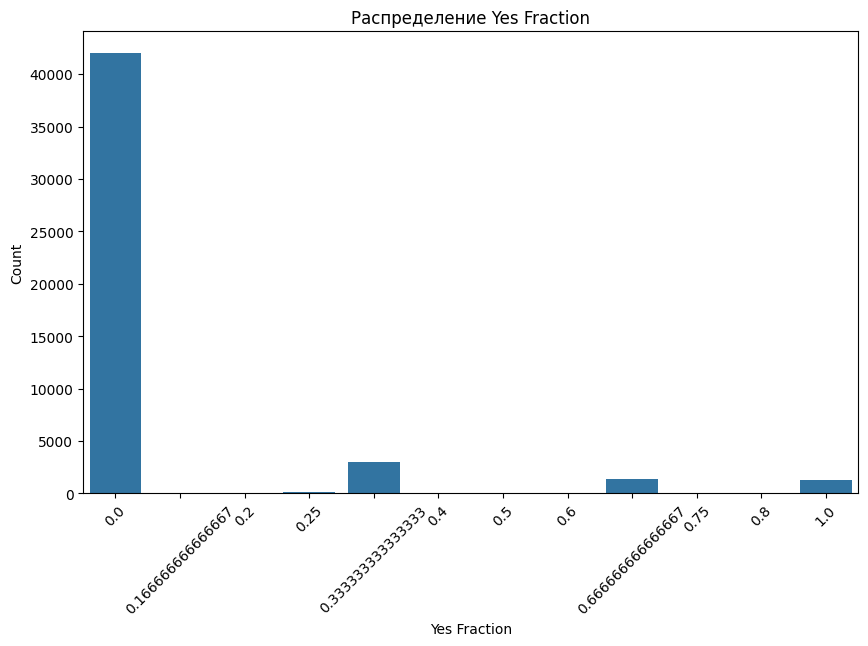

In [14]:
# Построим график
# Группируем данные по 'yes_fraction' и считаем количество вхождений
yes_fraction_counts = crowd_df['yes_fraction'].value_counts().reset_index()
yes_fraction_counts.columns = ['yes_fraction', 'count']

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x=yes_fraction_counts['yes_fraction'], y=yes_fraction_counts['count'])

# Настройки графика
plt.xlabel("Yes Fraction")
plt.ylabel("Count")
plt.title("Распределение Yes Fraction")
plt.xticks(rotation=45)  # Поворачиваем подписи оси X, если нужно
plt.show()

41970 участников, поставили оценку 0, которая значительно преобладает по сравнению с другими оценками.

In [15]:
# Проверим содержат ли столбцы 'yes_number', 'no_number'одновременно значения, равные нулю
crowd_df.loc[(crowd_df['yes_number']==0) & (crowd_df['no_number']==0)].sum()

image               0
description_id      0
yes_fraction      0.0
yes_number          0
no_number           0
dtype: object

In [16]:
# Посмотрим на уникальные комбинации image и description_id
print(f"Уникальных комбинаций image и description_id: {crowd_df[['image', 'description_id']].drop_duplicates().shape[0]}")

Уникальных комбинаций image и description_id: 47830


In [17]:
# Добавим новый столбец с общим количеством участников
crowd_df['total'] = crowd_df['yes_number'] + crowd_df['no_number']

In [18]:
crowd_df['total'].unique()

array([3, 4, 5, 6])

In [19]:
crowd_df.groupby('total')['total'].value_counts()

total
3    46780
4      780
5      220
6       50
Name: count, dtype: int64

### Выводы по анализу датафрейма с оценкой граждан
1. Датафрейм содержит 5 столбцов и 47830 строк, что почти в 9 раз больше, чем строк в датафрейме с оценками экспертов.
2. Этот датафрейм также содержит два столбца с ID изображений и текстов с типом даннх object. Столбец, содержащий среднюю оценку участников имеет тип данных float, и последние два столбца с количеством участников, которые дали либо положительную, либо отрицательную оценку, имеют тип данных int.
3. Датафрейм не содержит пропущенных данных.
4. Средняя оценка участников варьирует в пределах от 0 до 1, однако 41970 из 47830 участников поставили оценку 0.
5. Максимальное количество участников - 6, а минимальное 3. В основном в оценке принимали участие три человека (46780 из 47830) и намного реже больше трех.
6. Все комбинации изображений с соответствующими описаниями являются уникальными, дубликатов нет.

### Объединим две таблицы

In [20]:
# Объединяем таблицы по полям 'image' и 'description_id'
combined_df = pd.merge(
    expert_df[['image', 'description_id', 'normalized_score']],  # Оставляем только нужные столбцы из expert_df
    crowd_df[['image', 'description_id', 'yes_fraction', 'total']], # Оставляем нужные столбцы из crowd_df
    how = 'left', 
    on=['image', 'description_id']  # Объединение по этим полям
)
combined_df.sample(5)

image               description_id  \
498   1626754053_81126b67b6.jpg  2600867924_cd502fc911.jpg#2   
5664   747921928_48eb02aab2.jpg    53043785_c468d6f931.jpg#2   
5588    54501196_a9ac9d66f2.jpg  3064383768_f6838f57da.jpg#2   
2556  2932740428_b15384f389.jpg  2103568100_5d018c495b.jpg#2   
2446  2893374123_087f98d58a.jpg  3578841731_f775cab089.jpg#2   

      normalized_score  yes_fraction  total  
498           0.500000           0.0    3.0  
5664          0.250000           NaN    NaN  
5588          0.333333           NaN    NaN  
2556          0.250000           0.0    3.0  
2446          0.250000           0.0    3.0

In [21]:
combined_df.shape

(5822, 5)

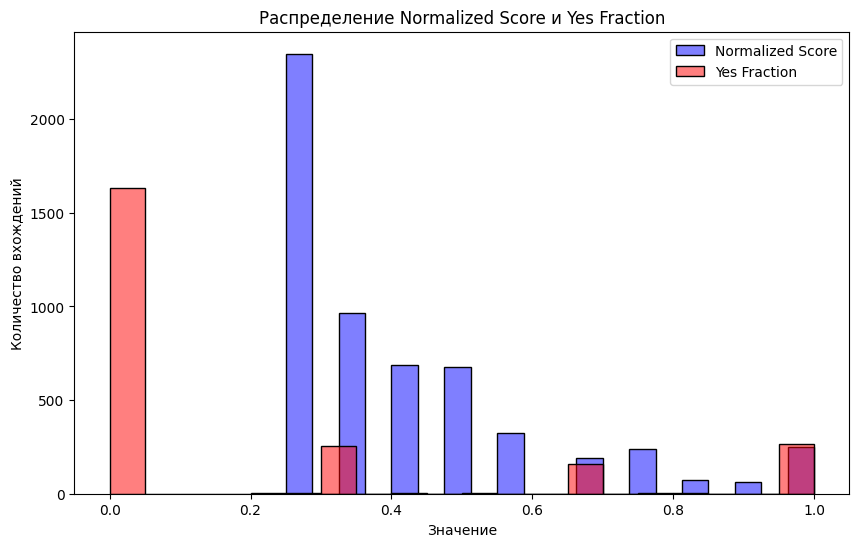

In [22]:
plt.figure(figsize=(10, 6))

# Гистограммы для двух колонок на одном графике
sns.histplot(combined_df['normalized_score'], bins=20, kde=False, color='blue', 
             label='Normalized Score', alpha=0.5)
sns.histplot(combined_df['yes_fraction'].dropna(), bins=20, kde=False, color='red', 
             label='Yes Fraction', alpha=0.5)

# Настройки графика
plt.xlabel("Значение")
plt.ylabel("Количество вхождений")
plt.title("Распределение Normalized Score и Yes Fraction")
plt.legend()
plt.show()

Из графика видно, что оценки экспертов и участников практически не совпадают и имеют разные распределения.

### Посмотрим как соотвествуют оценки экспертов и участников, выбрав 10 случайных изображений

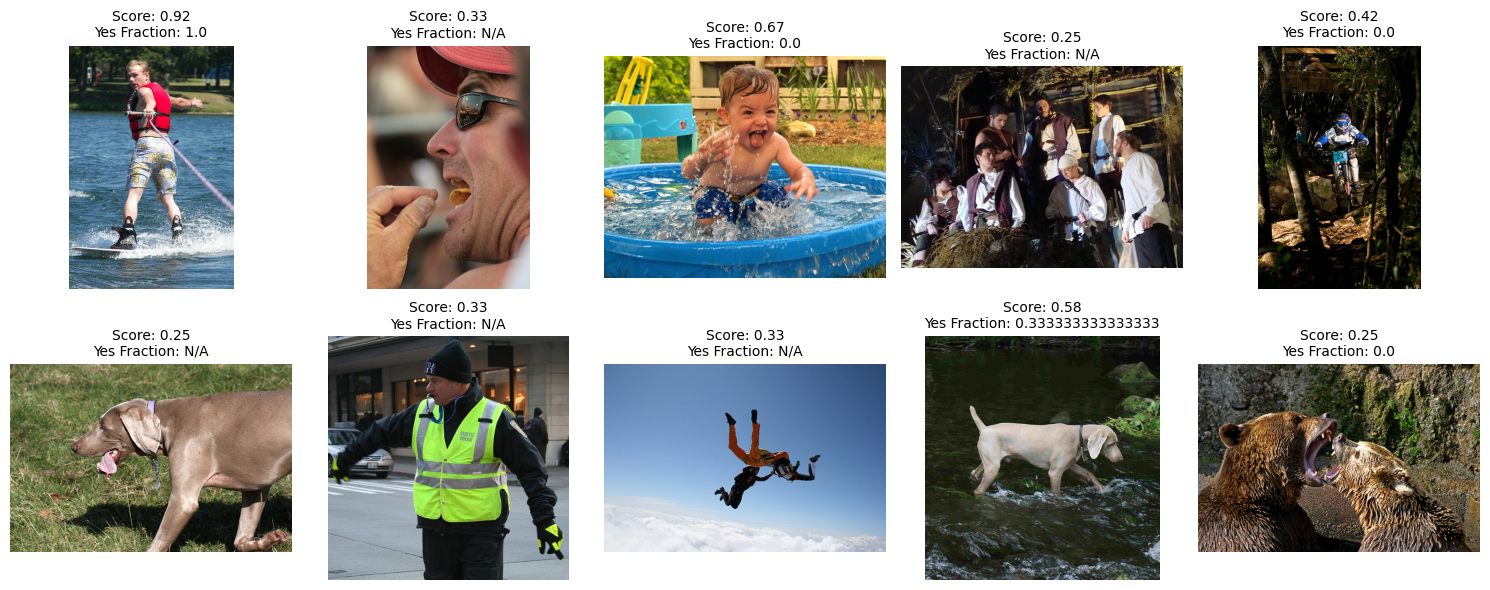

In [23]:
# Путь к файлу с изображениями
try:
    image_folder = path_to_prj + 'train_images'
except: print('Неверный путь')
    
# Выбираем случайные 10 изображений
sample_df = combined_df.sample(n=10, random_state=42)

# Создаем фигуру для отображения изображений
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, (_, row) in zip(axes.ravel(), sample_df.iterrows()):
    image_path = os.path.join(image_folder, row['image'])
    
    if os.path.exists(image_path):  # Проверяем, существует ли изображение
        img = Image.open(image_path)
        ax.imshow(img)
        ax.axis("off")
        title = f"Score: {row['normalized_score']:.2f}\nYes Fraction: {row['yes_fraction'] if not pd.isna(row['yes_fraction']) else 'N/A'}"
        ax.set_title(title, fontsize=10)

plt.tight_layout()
plt.show()

Можно видеть, что оценка экспертов и участников дво многих случаях сильно различаются.
Поэтому для вычисления общей оценки больший вес дадим оценке экспертов. 

In [24]:
# Функция для вычисления общей оценки
def calculate_common_norm_score(row):
    # Если в столбце учстников стоит NaN, то берется оценка экспертов
    if pd.isna(row['yes_fraction']):
        return row['normalized_score']
    # Если участников больше 4, то вес оценки экспертов зададим, равным 0.6, а если меньше - 0.7
    elif row['total'] > 4:
        return 0.5 * row['normalized_score'] + 0.5 * row['yes_fraction']
    else:
        return 0.6 * row['normalized_score'] + 0.4 * row['yes_fraction']

# Применяем функцию к датафрейму
combined_df['common_norm_score'] = combined_df.apply(calculate_common_norm_score, axis=1)

# Оставляем только нужные столбцы
result_df = combined_df[['image', 'description_id', 'common_norm_score']]

# Выводим первые строки итогового датафрейма
result_df.head()

image               description_id  common_norm_score
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2           0.150000
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2           0.200000
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2           0.333333
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2           0.416667
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2           0.333333

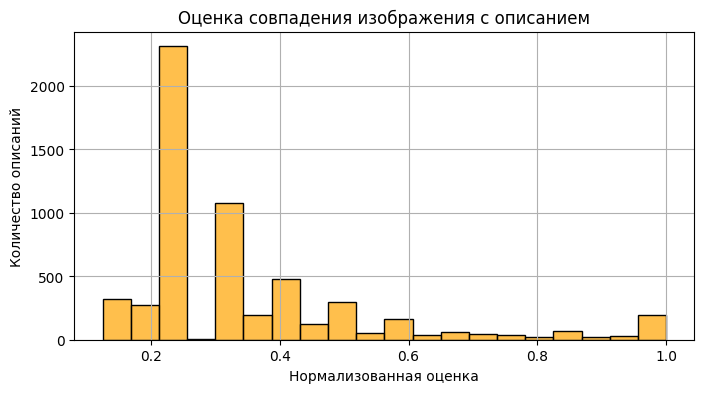

In [25]:
# Гистограмма для токсичных
plt.figure(figsize=(8, 4))
sns.histplot(result_df['common_norm_score'], kde=False, bins=20, color='orange', alpha=0.7, 
             label='Нормализованная оценка')
plt.title("Оценка совпадения изображения с описанием")
plt.xlabel("Нормализованная оценка")
plt.ylabel("Количество описаний")
plt.grid()
plt.show()

Можно видеть, что большинство изображений имеют оценку ниже 0,5. Полученный датафрейм имеет сильный перекос в сторону оценок меньше 0.5, что следует учесть на этапе обучения моделей.

### Загрузка тренировочных данных

In [26]:
# Загрузка данных с указанием разделителя и обработкой ошибочных строк
try:
    train_df = pd.read_csv(
    path_to_prj + 'train_dataset.csv',
    sep=',')
except: print('Неверный путь')
    
# Просмотр первых 5 строк
train_df.head(5)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [27]:
train_df.shape

(5822, 3)

In [28]:
print(f"Уникальных комбинаций image и query_id: {train_df[['image', 'query_text']].drop_duplicates().shape[0]}")

Уникальных комбинаций image и query_id: 5822


Для дальнейшей работы с текстом (query_text) выполним предобработку текста (очистку от лишних знаков и пробелов, приведем все к нижнему регистру, уберем стоп-слова и выполним лемматизацию.

In [29]:
# Загружаем модель SpaCy
nlp = spacy.load("en_core_web_sm")

# Функция для очистки текста
def clean_text(text):
    # Приводим текст к нижнему регистру
    text = text.lower()
    # Убираем знаки препинания, цифры и неанглийские символы
    text = re.sub(r'[^a-z\s]', '', text)
    return text

# Функция для лемматизации текста
def lemmatize_text(text):
    doc = nlp(text)
    # Лемматизируем и убираем стоп-слова
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

# Обработка текста
def process_text(text):
    text = clean_text(text)  # Очистка текста
    text = lemmatize_text(text)  # Лемматизация
    return text

# Применяем обработку к колонке query_text
train_df['processed_text'] = train_df['query_text'].apply(process_text)
train_df.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  \
0  A young child is wearing blue goggles and sitt...   
1  A young child is wearing blue goggles and sitt...   
2  A young child is wearing blue goggles and sitt...   
3  A young child is wearing blue goggles and sitt...   
4  A young child is wearing blue goggles and sitt...   

                                processed_text  
0  young child wear blue goggle sit float pool  
1  young child wear blue goggle sit float pool  
2  young child wear blue goggle sit float pool  
3  young child wear blue goggle sit float pool  
4  young child wear blue goggle sit float pool

In [30]:
# Проверим длину слов
# Добавление средней длины слова в токене
train_df['avg_word_length'] = train_df['processed_text'].apply(
lambda x: sum(len(word) for word in x.split())/len(x.split()) if len(x.split()) >0 else 0)

train_df.describe()

avg_word_length
count      5822.000000
mean          4.911434
std           0.809258
min           3.333333
25%           4.333333
50%           4.800000
75%           5.333333
max          11.000000

Очень длинные слова отсутствуют.

In [31]:
# Удаляем строки, где в описаниях упоминаются дети или возраст до 16 лет
keywords = ['child', 'children', 'boy', 'girl', 'baby', 'kid', 'under 16', 'younger than 16']
train_df = train_df[~train_df['query_text'].str.contains('|'.join(keywords), case=False, na=False)]

# Проверяем результат
print(f"Количество оставшихся записей: {len(train_df)}")

Количество оставшихся записей: 4275


#### Выводы
1. Загружены тренировочные данные, количество строк в которых совпадает с количеством строк в датафрейме оценки экспертов.
2. Все комбинации изображений с соответствующими описаниями являются уникальными, дубликатов нет.
3. Самое длинное слово содержит 11 знаков, артефактов нет.
4. Выполнена предварительная обработка текста.
5. После удаления дисклаймера датафрейи сократился до 4275 записей. 

### Обработка текстов

In [32]:
# Для обработки текстов используем BERT
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

# Токенизация текста и сохранение токенов в новую колонку
train_df['tokenized_text'] = train_df['query_text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True)
)

# Паддинг токенов для одинаковой длины
max_len = max(train_df['tokenized_text'].apply(len))
padded = np.array([i + [0] * (max_len - len(i)) for i in train_df['tokenized_text']])

# Attention mask
attention_mask = np.where(padded != 0, 1, 0)

# Преобразование текста в векторы с помощью BERT
batch_size = 100
embeddings = []

for i in notebook.tqdm(range((padded.shape[0] + batch_size - 1) // batch_size)):
    batch = torch.LongTensor(padded[batch_size * i: batch_size * (i + 1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i: batch_size * (i + 1)])
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
    # Сохраняем векторы CLS токена
    embeddings.append(batch_embeddings[0][:, 0, :].numpy())

# Объединяем все батчи в один массив
embeddings = np.concatenate(embeddings, axis=0)

# Добавляем векторы в DataFrame
train_df['embeddings'] = list(embeddings)

  0%|          | 0/43 [00:00<?, ?it/s]

In [33]:
print(f"Форма эмбеддингов: {embeddings.shape}")

Форма эмбеддингов: (4275, 768)


In [34]:
train_df.sample(5)

image                     query_id  \
1541  3630332976_fdba22c50b.jpg   241345811_46b5f157d4.jpg#2   
1813   348380010_33bb0599ef.jpg   293881927_ac62900fd4.jpg#2   
2344  2854959952_3991a385ab.jpg  1626754053_81126b67b6.jpg#2   
4848   247637795_fdf26a03cf.jpg  2421446839_fe7d46c177.jpg#2   
2872  2358898017_24496b80e8.jpg  2600867924_cd502fc911.jpg#2   

                                             query_text  \
1541  A football player in red and white is talking ...   
1813                            The dog is on the fence   
2344  A black and white dog prepares to catch a Fris...   
4848  A small black and white dog jumps at a woman i...   
2872  Two dogs , one brown and white and one black a...   

                                         processed_text  avg_word_length  \
1541               football player red white talk coach         5.166667   
1813                                          dog fence         4.000000   
2344              black white dog prepare catch frisbee         5.333333   
4848  small black white dog jump woman white jeep go...         4.636364   
2872          dog   brown white black white   run field         4.428571   

                                         tokenized_text  \
1541  [101, 1037, 2374, 2447, 1999, 2417, 1998, 2317...   
1813     [101, 1996, 3899, 2003, 2006, 1996, 8638, 102]   
2344  [101, 1037, 2304, 1998, 2317, 3899, 20776, 200...   
4848  [101, 1037, 2235, 2304, 1998, 2317, 3899, 1452...   
2872  [101, 2048, 6077, 1010, 2028, 2829, 1998, 2317...   

                                             embeddings  
1541  [0.0044381833, 0.56533647, -0.5676071, 0.05423...  
1813  [-0.07326699, 0.26424694, 0.14336959, -0.18487...  
2344  [-0.38705862, 0.34262374, -0.5826402, -0.33597...  
4848  [0.07794575, 0.36938682, -0.27725065, 0.161222...  
2872  [-0.43302873, -0.14207743, -0.72628254, 0.1900...

In [35]:
train_df.shape

(4275, 7)

### Обработка изображений

In [36]:
# Создаем экземпляр ImageDataGenerator 
datagen = ImageDataGenerator(
    rescale=1.0/255,  # Нормализация (значения пикселей от 0 до 1)
    horizontal_flip=True,
    vertical_flip=True
)

# Указываем директорию с изображениями
try:
    image_dir = path_to_prj + 'train_images' 
except: print('Неверный путь')
batch_size = 32  

datagen = ImageDataGenerator(rescale=1.0 / 255)

# Генератор данных с учётом двух полей
data_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,         # Директория с изображениями
    x_col="image",               # Поле с путём к изображению
    y_col="query_id",            # Уникальный идентификатор (для отслеживания описаний)
    target_size=(224, 224),      # Размеры для ResNet50
    batch_size=32,               # Размер батча
    class_mode=None,             # Извлекаем только эмбеддинги
    shuffle=False                # Не перемешиваем порядок
)

Found 4275 validated image filenames.


In [37]:
# Для обработки изображений используем ResNet50
resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')
resnet.trainable = False  # Замораживаем веса модели

# Извлечение эмбеддингов
embeddings = []

for i, batch in enumerate(tqdm(data_generator, total=len(data_generator), desc="Processing Batches")):
    # Предобработка батча
    batch = preprocess_input(batch)
    
    # Извлечение эмбеддингов
    batch_embeddings = resnet.predict(batch, verbose=0)
    embeddings.extend(batch_embeddings)
    
    # Прерывание после обработки всех батчей
    if i + 1 >= len(data_generator):
        print(f"Обработка завершена на {i + 1} батчах.")
        break

# Преобразование эмбеддингов в массив
embeddings = np.array(embeddings)
print(f"Форма эмбеддингов: {embeddings.shape}")

Processing Batches:  99%|████████████████████▊| 133/134 [02:01<00:00,  1.10it/s]

Обработка завершена на 134 батчах.
Форма эмбеддингов: (4275, 2048)


In [38]:
# Добавление эмбеддингов в DataFrame
train_df['image_embeddings'] = list(embeddings)
train_df.head()

image                     query_id  \
22  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
23  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
24   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
25   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
26   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                         query_text  \
22  A man sleeps under a blanket on a city street .   
23  A man sleeps under a blanket on a city street .   
24  A man sleeps under a blanket on a city street .   
25  A man sleeps under a blanket on a city street .   
26  A man sleeps under a blanket on a city street .   

                   processed_text  avg_word_length  \
22  man sleep blanket city street              5.0   
23  man sleep blanket city street              5.0   
24  man sleep blanket city street              5.0   
25  man sleep blanket city street              5.0   
26  man sleep blanket city street              5.0   

                                       tokenized_text  \
22  [101, 1037, 2158, 25126, 2104, 1037, 8768, 200...   
23  [101, 1037, 2158, 25126, 2104, 1037, 8768, 200...   
24  [101, 1037, 2158, 25126, 2104, 1037, 8768, 200...   
25  [101, 1037, 2158, 25126, 2104, 1037, 8768, 200...   
26  [101, 1037, 2158, 25126, 2104, 1037, 8768, 200...   

                                           embeddings  \
22  [0.2259451, -0.14777008, -0.41042694, 0.009856...   
23  [0.2259451, -0.14777008, -0.41042694, 0.009856...   
24  [0.2259451, -0.14777008, -0.41042694, 0.009856...   
25  [0.2259451, -0.14777008, -0.41042694, 0.009856...   
26  [0.2259451, -0.14777008, -0.41042694, 0.009856...   

                                     image_embeddings  
22  [0.0, 0.0, 0.0, 0.0, 0.003062022, 0.0, 0.0, 0....  
23  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018...  
24  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
25  [0.0, 0.0, 0.0, 0.003971932, 0.0, 0.0, 0.0, 0....  
26  [0.0, 0.0, 0.0, 0.0029963814, 0.0, 0.0, 0.0037...

In [39]:
train_df.shape

(4275, 8)

In [40]:
# Объединение DataFrame по колонке `image`
merged_df = train_df.merge(result_df, left_on=['image', 'query_id'], right_on=['image', 'description_id'], how='inner')

# Посмотрим на результат
merged_df.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
1  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
2   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
3   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
4   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   

                                        query_text  \
0  A man sleeps under a blanket on a city street .   
1  A man sleeps under a blanket on a city street .   
2  A man sleeps under a blanket on a city street .   
3  A man sleeps under a blanket on a city street .   
4  A man sleeps under a blanket on a city street .   

                  processed_text  avg_word_length  \
0  man sleep blanket city street              5.0   
1  man sleep blanket city street              5.0   
2  man sleep blanket city street              5.0   
3  man sleep blanket city street              5.0   
4  man sleep blanket city street              5.0   

                                      tokenized_text  \
0  [101, 1037, 2158, 25126, 2104, 1037, 8768, 200...   
1  [101, 1037, 2158, 25126, 2104, 1037, 8768, 200...   
2  [101, 1037, 2158, 25126, 2104, 1037, 8768, 200...   
3  [101, 1037, 2158, 25126, 2104, 1037, 8768, 200...   
4  [101, 1037, 2158, 25126, 2104, 1037, 8768, 200...   

                                          embeddings  \
0  [0.2259451, -0.14777008, -0.41042694, 0.009856...   
1  [0.2259451, -0.14777008, -0.41042694, 0.009856...   
2  [0.2259451, -0.14777008, -0.41042694, 0.009856...   
3  [0.2259451, -0.14777008, -0.41042694, 0.009856...   
4  [0.2259451, -0.14777008, -0.41042694, 0.009856...   

                                    image_embeddings  \
0  [0.0, 0.0, 0.0, 0.0, 0.003062022, 0.0, 0.0, 0....   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.003971932, 0.0, 0.0, 0.0, 0....   
4  [0.0, 0.0, 0.0, 0.0029963814, 0.0, 0.0, 0.0037...   

                description_id  common_norm_score  
0  3181701312_70a379ab6e.jpg#2           0.333333  
1  3181701312_70a379ab6e.jpg#2           0.416667  
2  3181701312_70a379ab6e.jpg#2           0.300000  
3  3181701312_70a379ab6e.jpg#2           0.416667  
4  3181701312_70a379ab6e.jpg#2           0.333333

In [41]:
merged_df.shape

(4275, 10)

После объединения тренировочных данных с данными по оценке изображений и текстов, получаем датафрейм с количеством строк 4275. 

### Обучение модели

In [42]:
# Создание финального датасета, с которым будем работать
resulted_train_df = merged_df[['image', 'query_id', 'embeddings', 'image_embeddings', 'common_norm_score']].copy()

In [43]:
# Устанавливаем порог для бинаризации
threshold = 0.5
resulted_train_df['target'] = (resulted_train_df['common_norm_score'] >= threshold).astype(int)

In [44]:
# Определим количество оценок, равное 0 и 1
resulted_train_df['target'].value_counts()

target
0    3483
1     792
Name: count, dtype: int64

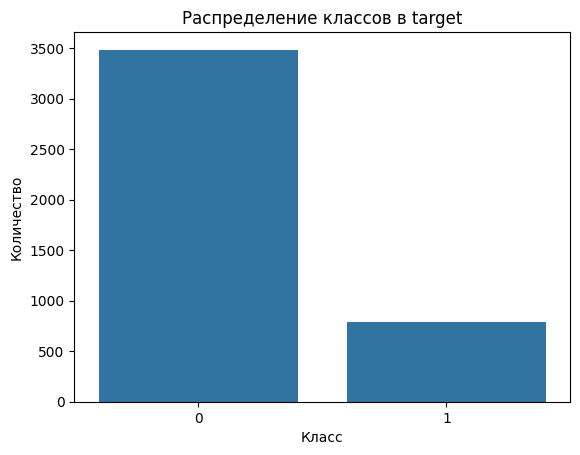

In [45]:
# Построение бар-диаграммы
sns.countplot(x=resulted_train_df['target'])

# Настройки графика
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.title("Распределение классов в target")

# Отображение
plt.show()

Видно, что выборка очень несбалансирована по целевому признаку.

In [46]:
# Разделение данных
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(
    resulted_train_df, 
    groups=resulted_train_df['image'] 
))

# Создание тренировочного и валидационного наборов
train_df = resulted_train_df.iloc[train_idx].reset_index(drop=True)
val_df = resulted_train_df.iloc[val_idx].reset_index(drop=True)

print(f"Размер тренировочного набора: {len(train_df)}")
print(f"Размер валидационного набора: {len(val_df)}")

Размер тренировочного набора: 3430
Размер валидационного набора: 845


In [47]:
# Поскольку размерность эмбедингов после обработки текста меньше (768), чем размерность image_embeddings
# Приведем размерность image_embeddings к 768
pca = PCA(n_components=768)
train_df['reduced_image_embeddings'] = list(pca.fit_transform(np.stack(train_df['image_embeddings'])))
val_df['reduced_image_embeddings'] = list(pca.transform(np.stack(val_df['image_embeddings'])))

# Объединение текстовых и визуальных эмбеддингов
def combine_embeddings(row):
    return np.concatenate([row['embeddings'], row['reduced_image_embeddings']])

train_df['combined_embeddings'] = train_df.apply(combine_embeddings, axis=1)
val_df['combined_embeddings'] = val_df.apply(combine_embeddings, axis=1)

# Преобразование в массивы
X_train = np.stack(train_df['combined_embeddings'].values)
y_train = train_df['target']
X_val = np.stack(val_df['combined_embeddings'].values)
y_val = val_df['target']

### Выбор наилучшей модели из нейронных сетей LightGBM, LogisticRegression и HistGradientBoostingClassifier

In [48]:
# Создаём Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Словари для хранения результатов
auc_scores_nn = []
auc_scores_lr = []
auc_scores_lgb = []
auc_scores_hgb = []

for train_index, val_index in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # 1. Нейросеть
    nn_model = Sequential([
        Input(shape=(X_train_fold.shape[1],)),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    nn_model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)
    val_pred_nn = nn_model.predict(X_val_fold).flatten()
    auc_scores_nn.append(roc_auc_score(y_val_fold, val_pred_nn))

    # 2. Логистическая регрессия
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X_train_fold, y_train_fold)
    val_pred_lr = lr_model.predict_proba(X_val_fold)[:, 1]
    auc_scores_lr.append(roc_auc_score(y_val_fold, val_pred_lr))

    # 3. LightGBM
    lgb_model = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, force_col_wise=True, random_state=42)
    lgb_model.fit(X_train_fold, y_train_fold)
    val_pred_lgb = lgb_model.predict_proba(X_val_fold)[:, 1]
    auc_scores_lgb.append(roc_auc_score(y_val_fold, val_pred_lgb))

    # 4. HistGradientBoosting
    hgb_model = HistGradientBoostingClassifier(max_iter=500, learning_rate=0.05, random_state=42)
    hgb_model.fit(X_train_fold, y_train_fold)
    val_pred_hgb = hgb_model.predict_proba(X_val_fold)[:, 1]
    auc_scores_hgb.append(roc_auc_score(y_val_fold, val_pred_hgb))

# Вывод результатов
print(f"Средний ROC-AUC для нейросети: {np.mean(auc_scores_nn):.4f}")
print(f"Средний ROC-AUC для логистической регрессии: {np.mean(auc_scores_lr):.4f}")
print(f"Средний ROC-AUC для LightGBM: {np.mean(auc_scores_lgb):.4f}")
print(f"Средний ROC-AUC для HistGradientBoosting: {np.mean(auc_scores_hgb):.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[LightGBM] [Info] Number of positive: 501, number of negative: 2243
[LightGBM] [Info] Total Bins 389574
[LightGBM] [Info] Number of data points in the train set: 2744, number of used features: 1536
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182580 -> initscore=-1.498963
[LightGBM] [Info] Start training from score -1.498963
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[LightGBM] [Info] Number of positive: 501, number of negative: 2243
[LightGBM] [Info] Total Bins 389626
[LightGBM] [Info] Number of data points in the train set: 2744, number of used features: 1536
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182580 -> initscore=-1.498963
[LightGBM] [Info] Start training from score -1.498963
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[LightGBM] [Info] Number of positive: 501, number of negative: 2243
[LightGBM] [Info] Total Bins 389384
[LightGBM] [Info] Number of data points in the train set: 2744, number of used features: 1536
[LightGBM] [Info] 

Наилучшими моделями оказались HistGradientBoosting (Средний ROC-AUC: 0.679) и LightGBM (Средний ROC-AUC: 0.677)

Поскольку выборка несбалансирована, количество оценок = 0 сильно превышает количество оценок =1, для улучшения обучения используем метод SMOTE

In [49]:
# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Распределение классов после SMOTE:")
print(pd.Series(y_resampled).value_counts())


Распределение классов после SMOTE:
target
0    2804
1    2804
Name: count, dtype: int64


In [50]:
# Вычисляем веса для классов
classes = np.array([0, 1])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_resampled)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Вес для класса 0: {class_weights[0]}, вес для класса 1: {class_weights[1]}")

Вес для класса 0: 1.0, вес для класса 1: 1.0


К сбалансированной тренировочной выборке применим модели LightGBM и HistGradientBoostingClassifier 

In [51]:
# Списки для сохранения результатов
auc_scores_lgb = []
auc_scores_hgb = []

for train_index, val_index in kf.split(X_resampled, y_resampled):
    X_train_fold, X_val_fold = X_resampled[train_index], X_resampled[val_index]
    y_train_fold, y_val_fold = y_resampled[train_index], y_resampled[val_index]
    
    # LightGBM модель
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
        class_weight='balanced',  # Учитываем дисбаланс классов
        force_col_wise=True
    )
    
    lgb_model.fit(X_train_fold, y_train_fold)
    val_predictions_lgb = lgb_model.predict_proba(X_val_fold)[:, 1]
    roc_auc_lgb = roc_auc_score(y_val_fold, val_predictions_lgb)
    auc_scores_lgb.append(roc_auc_lgb)
    
    # HistGradientBoosting
    hgb_model = HistGradientBoostingClassifier(
        max_iter=500, 
        learning_rate=0.05, 
        random_state=42
    )
    
    hgb_model.fit(X_train_fold, y_train_fold)
    val_pred_hgb = hgb_model.predict_proba(X_val_fold)[:, 1]
    auc_scores_hgb.append(roc_auc_score(y_val_fold, val_pred_hgb))
# Средние ROC-AUC
print(f"Средний ROC-AUC для LightGBM: {np.mean(auc_scores_lgb):.4f}")
print(f"Средний ROC-AUC для HistGradientBoosting: {np.mean(auc_scores_hgb):.4f}")   

[LightGBM] [Info] Number of positive: 2243, number of negative: 2243
[LightGBM] [Info] Total Bins 391405
[LightGBM] [Info] Number of data points in the train set: 4486, number of used features: 1536
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2243, number of negative: 2243
[LightGBM] [Info] Total Bins 391425
[LightGBM] [Info] Number of data points in the train set: 4486, number of used features: 1536
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2243, number of negative: 2243
[LightGBM] [Info] Total Bins 391392
[LightGBM] [Info] Number of data points in the train set: 4486, number of used features: 1536
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2244, number of negative: 2243
[LightGBM] [Info] Total Bins 391383
[LightGBM] [Info] Number of data points in the train set: 448

Лучшей моделью является HistGradientBoosting со значением ROC-AUC: 0.977. Применим эту модель к тестовым данным

### Обработка тестовых данных

In [52]:
# Загрузка данных с указанием разделителя и обработкой ошибочных строк
try:
    test_df = pd.read_csv(
    path_to_prj + 'test_queries.csv',
    sep='|', 
    index_col=0  # Не считывать первый столбец как индекс
    )
except: print('Неверный путь')
# Просмотр первых 5 строк
test_df.head(5)

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [53]:
test_df.shape

(500, 3)

In [54]:
len(test_df['image'].unique())

100

In [55]:
# Применяем обработку к колонке query_text
test_df['processed_text'] = test_df['query_text'].apply(process_text)
test_df.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  \
0  1177994172_10d143cb8d.jpg   
1  1177994172_10d143cb8d.jpg   
2  1177994172_10d143cb8d.jpg   
3  1177994172_10d143cb8d.jpg   
4  1177994172_10d143cb8d.jpg   

                                      processed_text  
0  blonde boy   camouflage shirt blue   have wate...  
1                               boy squirt water gun  
2                                    boy spray water  
3                       child wear jean squirt water  
4                             young boy squirt water

In [56]:
len(test_df['image'].unique())

100

In [57]:
print(f"Уникальных комбинаций image и description_id: {test_df[['image', 'query_id']].drop_duplicates().shape[0]}")

Уникальных комбинаций image и description_id: 500


#### Обработка текста

In [58]:

model = transformers.BertModel.from_pretrained('bert-base-uncased')

# Токенизация текста и сохранение токенов в новую колонку
test_df['tokenized_text'] = test_df['query_text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True)
)

# Определение максимальной длины токенов
max_len = max(test_df['tokenized_text'].apply(len))

# Паддинг
padded = np.array([i + [0] * (max_len - len(i)) for i in test_df['tokenized_text']])

# Создание attention mask
attention_mask = np.where(padded != 0, 1, 0)

# Преобразование текста в векторы с помощью BERT
batch_size = 100
embeddings = []

for i in notebook.tqdm(range((padded.shape[0] + batch_size - 1) // batch_size)):
    batch = torch.LongTensor(padded[batch_size * i: batch_size * (i + 1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i: batch_size * (i + 1)])
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
    # Сохранение векторов CLS токена
    embeddings.append(batch_embeddings[0][:, 0, :].numpy())

# Объединение всех батчей в один массив
embeddings = np.concatenate(embeddings, axis=0)

# Добавление векторов в DataFrame
test_df['embeddings'] = list(embeddings)
print(f"Форма эмбеддингов: {embeddings.shape}")

  0%|          | 0/5 [00:00<?, ?it/s]

Форма эмбеддингов: (500, 768)


In [59]:
test_df.sample(5)

query_id  \
290  3330333217_1a69497a74.jpg#0   
218  3044745642_1d0784ff29.jpg#3   
6    1232148178_4f45cc3284.jpg#1   
384  3517023411_a8fbd15230.jpg#4   
455   634891010_9fa189effb.jpg#0   

                                            query_text  \
290  A black man in a blue shirt stands next to a b...   
218       Two people are in a tent near a brick wall .   
6    A closeup of a child on a playground with adul...   
384        Man rides on bicycle as other people walk .   
455  A black and white dog jumping out of the water...   

                         image                                 processed_text  \
290  3330333217_1a69497a74.jpg  black man blue shirt stand black man red robe   
218  3044745642_1d0784ff29.jpg                    people tent near brick wall   
6    1232148178_4f45cc3284.jpg     closeup child playground adult supervision   
384  3517023411_a8fbd15230.jpg                   man ride bicycle people walk   
455   634891010_9fa189effb.jpg     black white dog jump water brown dog shake   

                                        tokenized_text  \
290  [101, 1037, 2304, 2158, 1999, 1037, 2630, 3797...   
218  [101, 2048, 2111, 2024, 1999, 1037, 9311, 2379...   
6    [101, 1037, 2485, 6279, 1997, 1037, 2775, 2006...   
384  [101, 2158, 12271, 2006, 10165, 2004, 2060, 21...   
455  [101, 1037, 2304, 1998, 2317, 3899, 8660, 2041...   

                                            embeddings  
290  [0.11890187, 0.27910197, -0.3318297, -0.070850...  
218  [0.29056856, 0.6381143, -0.5135828, -0.5954713...  
6    [-0.71890396, -0.649822, -0.50296694, 0.306857...  
384  [0.105456755, 0.23107988, -0.04821633, 0.21152...  
455  [-0.48017335, 0.1271222, -0.6950119, 0.2378357...

In [60]:
# Директория с изображениями
try:
    image_test_dir =  path_to_prj + 'test_images' 
except: print('Неверный путь')
batch_size = 32  

datagen = ImageDataGenerator(rescale=1.0 / 255)

# Генератор данных с учётом двух полей
data_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_test_dir,    # Директория с изображениями
    x_col="image",               # Поле с путём к изображению
    y_col="query_id",            # Уникальный идентификатор (для отслеживания описаний)
    target_size=(224, 224),      # Размеры для ResNet50
    batch_size=32,               # Размер батча
    class_mode=None,             # Извлечение только эмбеддингов
    shuffle=False                # Отсутствие перемешивания порядка
)

Found 500 validated image filenames.


In [61]:
# Извлечение эмбеддингов для тестовых изображений
embeddings = []

for i, batch in enumerate(tqdm(data_generator, total=len(data_generator), desc="Processing Batches")):
    # Предобработка батча
    batch = preprocess_input(batch)
    
    # Извлечение эмбеддингов
    batch_embeddings = resnet.predict(batch, verbose=0)
    embeddings.extend(batch_embeddings)
    
    # Прерывание после обработки всех батчей
    if i + 1 >= len(data_generator):
        print(f"Обработка завершена на {i + 1} батчах.")
        break

# Преобразование эмбеддингов в массив
embeddings = np.array(embeddings)
print(f"Форма эмбеддингов: {embeddings.shape}")

Processing Batches:  94%|█████████████████████▌ | 15/16 [00:16<00:01,  1.13s/it]

Обработка завершена на 16 батчах.
Форма эмбеддингов: (500, 2048)


In [62]:
# Добавление эмбеддингов в DataFrame
test_df['image_embeddings'] = list(embeddings)
test_df.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  \
0  1177994172_10d143cb8d.jpg   
1  1177994172_10d143cb8d.jpg   
2  1177994172_10d143cb8d.jpg   
3  1177994172_10d143cb8d.jpg   
4  1177994172_10d143cb8d.jpg   

                                      processed_text  \
0  blonde boy   camouflage shirt blue   have wate...   
1                               boy squirt water gun   
2                                    boy spray water   
3                       child wear jean squirt water   
4                             young boy squirt water   

                                      tokenized_text  \
0  [101, 2048, 9081, 3337, 1010, 2028, 1999, 1037...   
1  [101, 2048, 3337, 2024, 5490, 10179, 24097, 23...   
2  [101, 2048, 3337, 29035, 2169, 2060, 2007, 230...   
3  [101, 2048, 2336, 4147, 6312, 5490, 10179, 533...   
4  [101, 2048, 2402, 3337, 2024, 5490, 10179, 240...   

                                          embeddings  \
0  [0.53365886, 0.3410315, -0.7350285, -0.2370495...   
1  [0.4731506, 0.5557899, -0.39326283, -0.4037186...   
2  [-0.25106284, 0.45822042, -0.83150184, 0.15650...   
3  [0.251959, 0.55996794, -0.68001705, -0.0540480...   
4  [0.6404596, 0.6084135, -0.4573957, -0.4459113,...   

                                    image_embeddings  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021...

In [63]:
test_df.shape

(500, 7)

In [64]:
print(f"Размерность текстовых эмбеддингов: {np.stack(test_df['embeddings']).shape}")

Размерность текстовых эмбеддингов: (500, 768)


In [65]:
# Исходные эмбеддинги
image_embeddings = np.stack(test_df['image_embeddings'].values)
print(f"Исходная размерность image_embeddings: {image_embeddings.shape}")

# Уменьшение размерности до 334 (с использованием PCA)
pca = PCA(n_components=334)
reduced_embeddings = pca.fit_transform(image_embeddings)
print(f"Размерность после PCA: {reduced_embeddings.shape}")

# Дополнение до 768 признаков
final_embeddings = np.pad(
    reduced_embeddings,
    pad_width=((0, 0), (0, 768 - reduced_embeddings.shape[1])),
    mode='constant'
)
print(f"Итоговая размерность: {final_embeddings.shape}")

# Добавление результата обратно в DataFrame
test_df['reduced_image_embeddings'] = list(final_embeddings)

Исходная размерность image_embeddings: (500, 2048)
Размерность после PCA: (500, 334)
Итоговая размерность: (500, 768)


In [66]:
# Объединение текстовых и визуальных эмбеддингов
def combine_embeddings(row):
    return np.concatenate([row['embeddings'], row['reduced_image_embeddings']])

# Создание новой колонки с объединенными эмбеддингами
test_df['combined_embeddings'] = test_df.apply(combine_embeddings, axis=1)

# Преобразование в массив для модели
X_test = np.stack(test_df['combined_embeddings'].values)
print(f"Итоговая размерность тестовых данных: {X_test.shape}")

Итоговая размерность тестовых данных: (500, 1536)


### Использование наилучшей модели для получения предсказаний на тестовой выборке

In [67]:
hgb_model = HistGradientBoostingClassifier(
        max_iter=500, 
        learning_rate=0.05, 
        random_state=42
    )
    
# Обучение модели
hgb_model.fit(X_resampled, y_resampled)

# Получение предсказаний (0 или 1)
test_predictions = hgb_model.predict(X_test)

In [68]:
# Добавление предсказаний в DataFrame
test_df['predictions'] = test_predictions
test_df[['query_text', 'predictions']].sample(15)

query_text  predictions
397  A man on a waterski is performing a jump in th...            1
11   Several female lacrosse players are going afte...            1
433  A woman in a red coat takes a picture near mar...            1
15         A brown dog is sitting in some long grass .            1
432     An older dark haired woman is taking a picture            0
475  A girl is wearing a blue wig under a brown hoo...            0
345  a lone man sitting on a ledge that overlooks t...            1
338  A man on an orange bike jumps in the air with ...            1
178  A cyclist riding on their front wheel on the a...            1
1    Two boys are squirting water guns at each other .            0
61    A boy in a blue shirt standing by a lake shore .            1
322  A group of people playing instruments in the w...            1
133                        Boys and girls at a party .            1
296  An Afican American woman standing behind two s...            0
447  Two boys in swimsuits standing under running w...            1

In [69]:
# Выбор 10 случайных описаний
random_queries = test_df.sample(n=10)
print(random_queries[['query_text', 'predictions']])

                                            query_text  predictions
43   A woman poses for a picture while in front of ...            1
211  A dog is jumping into a pool for a swim compet...            1
174        Young children shoot baskets in the field .            0
6    A closeup of a child on a playground with adul...            0
214  The furry black and white dog is running throu...            1
196  A little girl with her hands in the air is sit...            1
441               many people walk through the store .            1
198            A small girl sitting on a man 's back .            1
3    Two children wearing jeans squirt water at eac...            0
205    a blond man jumping off a cliff into some water            1


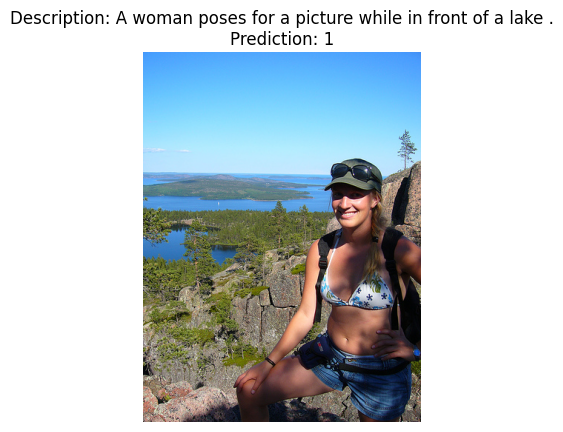

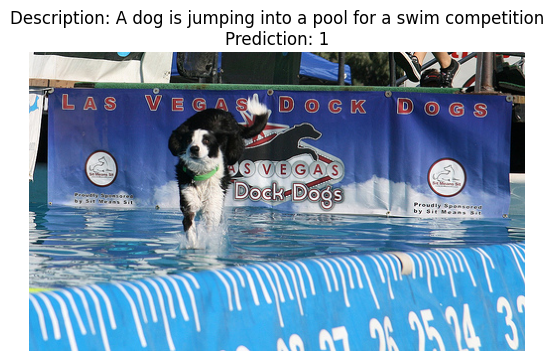

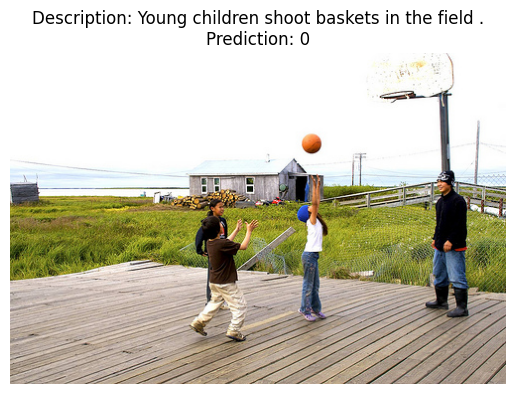

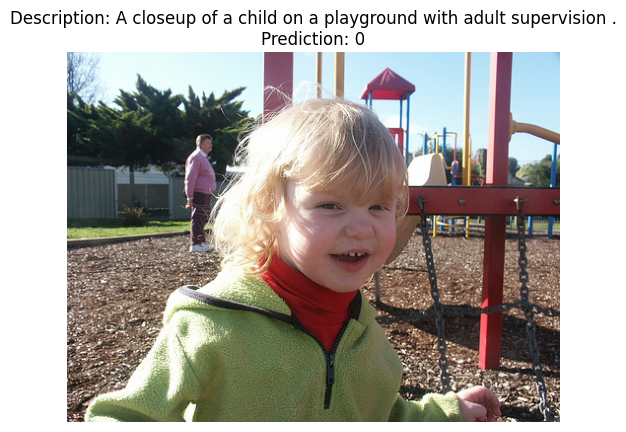

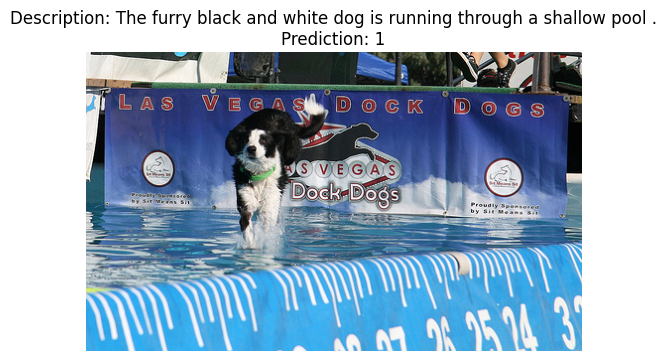

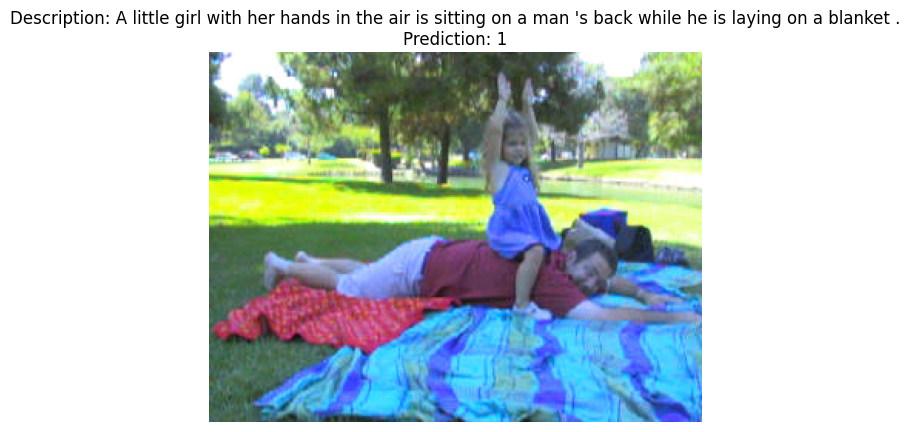

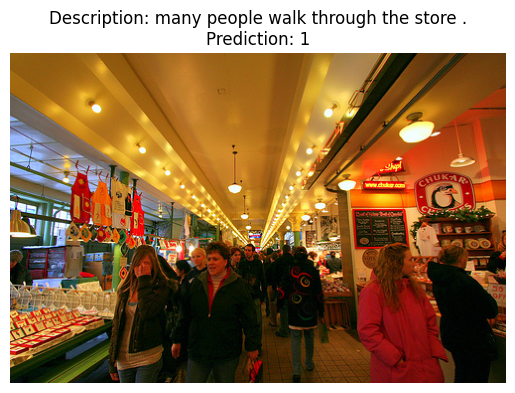

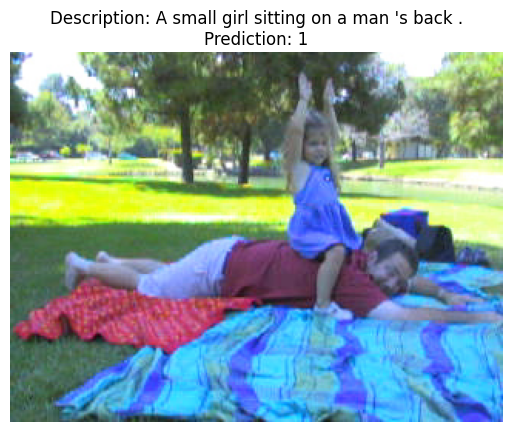

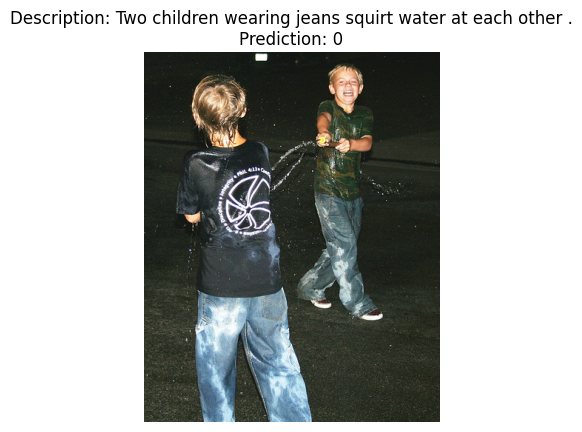

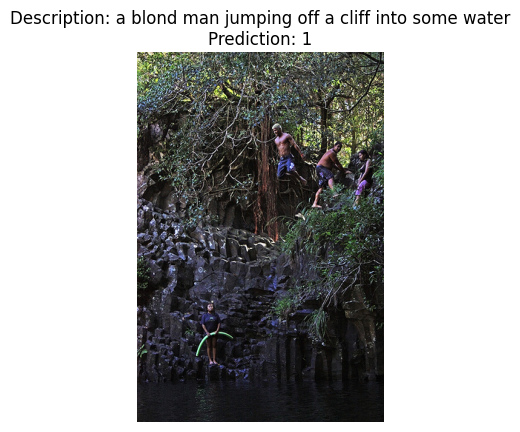

In [70]:
# Вывод изображений для выбранных описаний
try:
    image_dir = path_to_prj + 'test_images'  
except: print('Неверный путь')

for idx, row in random_queries.iterrows():
    image_path = os.path.join(image_dir, row['image'])  
    plt.figure()
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(f"Description: {row['query_text']}\nPrediction: {row['predictions']}")
    plt.axis('off')
    plt.show()

Изучение тренировочных данных показало:
1. пропущенные значения отсутствуют, все ячейки в датафрейме заполнены;
2. дублирования данных нет;
3. полученная тренировочная выборка не сбалансирована: значительно преобладает количество нулевых оценок;
4. оценки экспертов и участников сильно отличаются.

#### Обучение
1. Для получения сбалансированной выборки использован метод SMOTE
2. Для обработки текстов использована модель BERT
3. Изображения обработаны с помощью модели ResNet50
4. Для обучения были использованы нейронная модель, LogisticRegression и LGBMClassifier и HistGradientBoostingClassifier.
5. Для оценки выбран критерий ROC-AUC, поскольку выборка сильно несбаланстированная.

#### Результаты:
Лучшей моделью для предсказаний оказалась HistGradientBoostingClassifier со значением accuracy около 0,97.